In [339]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [340]:
import pandas as pd

In [341]:
import os, warnings
import re
warnings.filterwarnings(action='ignore')

In [342]:
### 한글 폰트 설정
import matplotlib
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import platform
path = "C:/Windows/Fonts/malgun.ttf"
if platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system()=="Darwin":
    rc('font', family='AppleGothic')
else:
    print("Unknown System")
matplotlib.rcParams['axes.unicode_minus'] = False

In [343]:
train=pd.read_csv('./train_df_errno.csv')
test=pd.read_csv('./test_df.csv')
sub=pd.read_csv('./sample_submission.csv')
age=pd.read_csv('./age_gender_info.csv')
train.shape, test.shape, sub.shape, age.shape

((2896, 15), (1008, 14), (150, 2), (16, 23))

In [344]:
# dataframe 너비 확대하기
pd.set_option('display.max_colwidth', None)
# dataframe row 개수 지정하기
pd.set_option("display.max_rows", 900)

In [345]:
train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,10분내지하철수,10분내버스정류장수,단지내주차면수,등록차량수
0,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000,82940,0.0,3.0,624.0,205.0
1,C2515,545,아파트,경상남도,국민임대,39.60,60,17.0,A,12672000,107130,0.0,3.0,624.0,205.0
2,C2515,545,아파트,경상남도,국민임대,39.60,20,17.0,A,12672000,107130,0.0,3.0,624.0,205.0
3,C2515,545,아파트,경상남도,국민임대,46.90,38,17.0,A,18433000,149760,0.0,3.0,624.0,205.0
4,C2515,545,아파트,경상남도,국민임대,46.90,19,17.0,A,18433000,149760,0.0,3.0,624.0,205.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2891,C2532,239,아파트,강원도,국민임대,49.20,19,7.0,A,11346000,116090,0.0,1.0,166.0,146.0
2892,C2532,239,아파트,강원도,국민임대,51.08,34,7.0,A,14005000,142310,0.0,1.0,166.0,146.0
2893,C2532,239,아파트,강원도,국민임대,51.73,34,7.0,A,14005000,142310,0.0,1.0,166.0,146.0
2894,C2532,239,아파트,강원도,국민임대,51.96,114,7.0,A,14005000,142310,0.0,1.0,166.0,146.0


In [346]:
train.isnull().sum()

단지코드            0
총세대수            0
임대건물구분          0
지역              0
공급유형            0
전용면적            0
전용면적별세대수        0
공가수             0
자격유형            0
임대보증금         569
임대료           569
10분내지하철수      211
10분내버스정류장수      4
단지내주차면수         0
등록차량수           0
dtype: int64

In [347]:
test.isnull().sum()

단지코드            0
총세대수            0
임대건물구분          0
지역              0
공급유형            0
전용면적            0
전용면적별세대수        0
공가수             0
자격유형            2
임대보증금         180
임대료           180
10분내지하철수       38
10분내버스정류장수      0
단지내주차면수         0
dtype: int64

# 관심있는 column과 데이터구분용 column선택

### 0721_등록차량수를 log취해서 정규분포로 바꿀까?

In [348]:
import matplotlib
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import numpy as np

(array([ 12.,   6.,  85., 180., 352., 314., 649., 781., 399., 118.]),
 array([2.56494936, 3.09283929, 3.62072921, 4.14861914, 4.67650907,
        5.204399  , 5.73228893, 6.26017885, 6.78806878, 7.31595871,
        7.84384864]),
 <BarContainer object of 10 artists>)

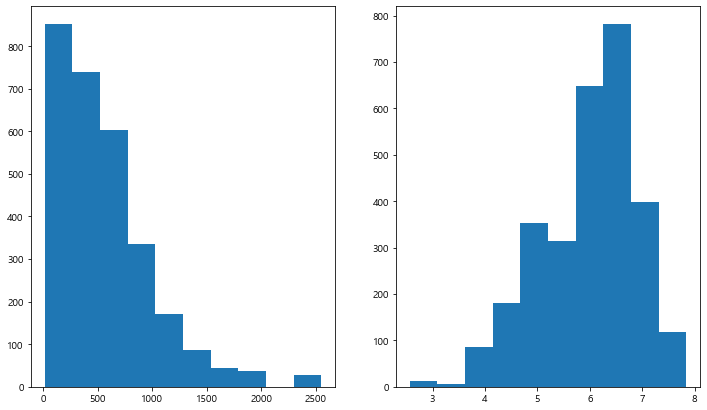

In [349]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,7))
ax1.hist(train['등록차량수'])
ax2.hist(np.log(train['등록차량수']))

In [350]:
# train['log_등록차량수'] = np.log1p(train['등록차량수'])

### 0721_전용면적별 세대의 합계와 총세대수가 일치하지 않는 오류
 - 오류1 14세대 이하 처리
 - 오류1 94~452세대 10개 단지 처리
 - 나머지 null값처리

In [351]:
group1 = ['C1925', 'C1312', 'C2013', 'C1424', 'C2520', 'C2319', 'C1850', 'C1068', 'C2644', 'C2156', 
          'C2453', 'C1910', 'C2139', 'C2508', 'C1695', 'C2556', 'C2362', 'C2568', 'C2245', 'C2549', 
          'C1584', 'C2298', 'C2225', 'C1218', 'C1970', 'C1732', 'C2433', 'C1894', 'C1156', 'C2142', 
          'C2186', 'C2411', 'C1812', 'C1030', 'C1749', 'C1349', 'C2043', 'C1229', 'C2363', 'C1414', 
          'C2174', 'C2404', 'C1683', 'C1038', 'C2456', 'C1266', 'C1267', 'C2189' ]
for one1 in group1:
    train.loc[ train['단지코드'] == one1, "단지코드_Type" ] = 1
    test.loc[ test['단지코드'] == one1, "단지코드_Type" ] = 1

In [352]:
group2=['C1490', 'C2497', 'C2620', 'C1344', 'C1024', 'C2470', 'C1206', 'C1740', 'C2405', 'C1804' ]
for one1 in group2:
    train.loc[train['단지코드'] == one1, '단지코드_Type']=2
    test.loc[test['단지코드'] == one1, '단지코드_Type']=2

In [353]:
train.loc[train['단지코드_Type'].isna(), "단지코드_Type"] = 3
test.loc[test['단지코드_Type'].isna(), "단지코드_Type"] = 3
print(train['단지코드_Type'].unique())
print(test['단지코드_Type'].unique())

[3. 1. 2.]
[3. 1. 2.]


In [354]:
count_ranks = abs(train.corr()["등록차량수"]).sort_values(ascending=False)
count_ranks

등록차량수         1.000000
단지내주차면수       0.861338
총세대수          0.333440
전용면적별세대수      0.250513
공가수           0.118910
전용면적          0.112717
단지코드_Type     0.109893
10분내지하철수      0.107308
10분내버스정류장수    0.104135
Name: 등록차량수, dtype: float64

<AxesSubplot:>

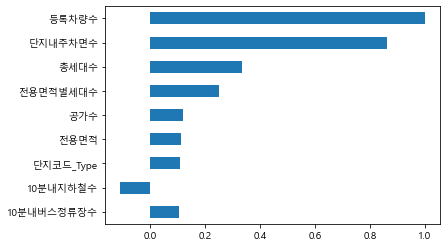

In [355]:
corr_ranks = abs(train.corr()["등록차량수"]).sort_values(ascending=False)
train.corr()["등록차량수"][corr_ranks.index[::-1]].plot(kind="barh")

### mapping: 자격유형, 공급유형, 지역, 임대건물구분 > 마지막에!...qcut할까?

In [356]:
#강사님꺼
test.loc[196,'자격유형']='A'
test.loc[258,'자격유형']='C'

In [357]:
test['자격유형'].isnull().sum()

0

In [358]:
train['자격유형'].unique()

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O'], dtype=object)

In [359]:
# mapping = { 'A':1, 'B':2, 'C':3, 'D':4, 'E':5,
#             'F':6, 'G':7, 'H':8, 'I':9, 'J':10,
#             'K':11, 'L':12, 'M':13, 'N':14, 'O':15  }
# train['자격유형']=train['자격유형'].map(mapping).astype('category')
# test['자격유형']=test['자격유형'].map(mapping).astype('category')

In [360]:
train['공급유형'].value_counts()

국민임대         1736
임대상가          562
행복주택          202
공공임대(10년)     182
영구임대          152
공공임대(50년)      31
공공임대(분납)       12
장기전세            9
공공분양            7
공공임대(5년)        3
Name: 공급유형, dtype: int64

In [361]:
# mapping = { '국민임대':1, '임대상가':2, '행복주택':3, '공공임대(10년)':4, 
#            '영구임대':5,'공공임대(50년)':6,
#            '공공임대(분납)':7, '장기전세':8, '공공분양':9, '공공임대(5년)':10 }
# train['공급유형'] =train['공급유형'].map(mapping).astype('category')
# test['공급유형'] =test['공급유형'].map(mapping).astype('category')

In [362]:
train['지역'].value_counts()

경기도        602
경상남도       369
부산광역시      328
대전광역시      266
강원도        187
충청북도       163
충청남도       158
전라남도       147
광주광역시      141
경상북도       111
전라북도       109
대구광역시      102
제주특별자치도     91
서울특별시       64
울산광역시       34
세종특별자치시     24
Name: 지역, dtype: int64

In [363]:
# mapping1 = { '경기도':1, '경상남도':2, '부산광역시':3, '대전광역시':4, 
#            '강원도':5,'충청북도':6,'충청남도':7, '전라남도':8, '광주광역시':9, 
#             '경상북도':10, '전라북도':11,'대구광역시':12,'제주특별자치도':13,'서울특별시':14,'세종특별자치시':15,'울산광역시':16 }
# train['지역'] =train['지역'].map(mapping1).astype('category')
# test['지역'] =test['지역'].map(mapping1).astype('category')

In [364]:
train['임대건물구분'].unique()

array(['아파트', '상가'], dtype=object)

In [365]:
# mapping2 = { '아파트':1, '상가':2}
# train['임대건물구분'] =train['임대건물구분'].map(mapping2).astype('category')
# test['임대건물구분'] =test['임대건물구분'].map(mapping2).astype('category')

### 구간 qcut

In [366]:
# train['qcut_총세대수'] = pd.qcut(train['총세대수'], 10, labels=False)
# test['qcut_총세대수'] = pd.qcut(test['총세대수'], 10, labels=False)

In [367]:
# train['qcut_10분내버스정류장수'] = pd.qcut(train['10분내버스정류장수'], 10, labels=False,duplicates='drop')
# test['qcut_10분내버스정류장수'] = pd.qcut(test['10분내버스정류장수'], 10, labels=False,duplicates='drop')

In [368]:
# train['qcut_전용면적별세대수'] = pd.qcut(train['전용면적별세대수'], 10, labels=False,duplicates='drop')
# test['qcut_전용면적별세대수'] = pd.qcut(test['전용면적별세대수'], 10, labels=False,duplicates='drop')

In [369]:
# train['qcut_공가수'] = pd.qcut(train['공가수'], 10, labels=False)
# test['qcut_공가수'] = pd.qcut(test['공가수'], 10, labels=False)

### 전용면적에 제한두기 > dacon baseline 공지사항 반영
(https://dacon.io/competitions/official/235745/codeshare/2839)

In [370]:
train['전용면적'] = train['전용면적']//5*5
test['전용면적'] = test['전용면적']//5*5

In [371]:
idx = train[train['전용면적']>100].index
train.loc[idx, '전용면적'] = 100
idx = test[test['전용면적']>100].index
test.loc[idx, '전용면적'] = 100

idx = train[train['전용면적']<15].index
train.loc[idx, '전용면적'] = 15
idx = test[test['전용면적']<15].index
test.loc[idx, '전용면적'] = 15

In [372]:
test['전용면적'].unique()

array([ 35.,  45.,  50.,  30.,  55.,  25.,  75., 100.,  15.,  20.,  40.,
        60.,  80.,  70.])

### 0720_항목 묶어서 비중높은 feature 바꾸기/ 이상치 제거해야할까?!

In [373]:
train.corr()['등록차량수']

총세대수          0.333440
전용면적          0.335886
전용면적별세대수      0.250513
공가수           0.118910
10분내지하철수     -0.107308
10분내버스정류장수    0.104135
단지내주차면수       0.861338
등록차량수         1.000000
단지코드_Type     0.109893
Name: 등록차량수, dtype: float64

In [374]:
#주차면수 대비 등록차량 비율이 높을 수록 주차수요가 높을것이다.
# > 확인가능. 피처로 사용 불가. 왜? test에 등록차량수 넣으면 데이터 과대적합 ↑
# > 지역별로 봐야겠다.
train['주차면수 대비 등록차량 비율']=train['등록차량수']/train['단지내주차면수']
test['주차면수 대비 등록차량 비율']=train['등록차량수']/test['단지내주차면수']

In [375]:
# train.loc[train['주차면수 대비 등록차량 비율'],:].sort_values(by=['지역'])

In [376]:
# plt.figure(figsize=(8,6))
# plt.bar(x=train['지역'],y=train['주차면수 대비 등록차량 비율'])
# plt.title('주차면수 대비 등록차량 비율')
# plt.show()

In [377]:
#주차면수 대비 총세대수가 높을 수록 주차수요가 높을것이다
train['주차면수 대비 총세대수']=train['단지내주차면수']/train['총세대수']
test['주차면수 대비 총세대수']=test['단지내주차면수']/test['총세대수']

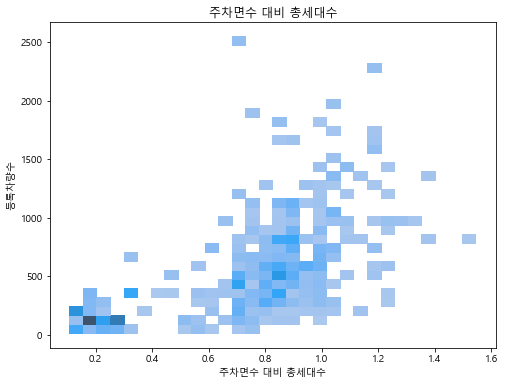

In [378]:
plt.figure(figsize=(8,6))
sns.histplot(x=train['주차면수 대비 총세대수'],y=train['등록차량수'],data=train)
plt.title('주차면수 대비 총세대수')
plt.show()

In [379]:
#주차면수 대비 전용면적별세대수가 높을 수록 주차수요가 높을것이다
train['주차면수 대비 전용면적별세대수']=train['단지내주차면수']/train['전용면적별세대수']
test['주차면수 대비 전용면적별세대수']=test['단지내주차면수']/test['전용면적별세대수']

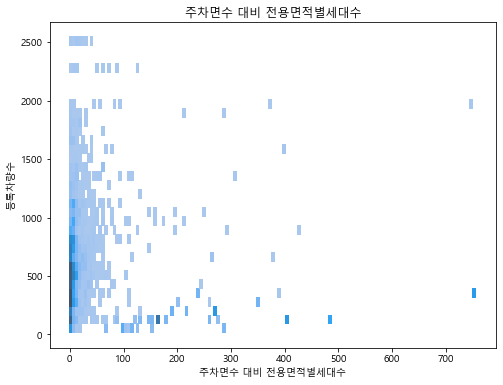

In [380]:
plt.figure(figsize=(8,6))
sns.histplot(x=train['주차면수 대비 전용면적별세대수'],y=train['등록차량수'],data=train)
plt.title('주차면수 대비 전용면적별세대수')
plt.show()

In [381]:
#거주율이 높을 수록 주차수요가 높을 것이다.
train['거주율']=1-(train['공가수']/train['총세대수'])
test['거주율']=1-(test['공가수']/test['총세대수'])

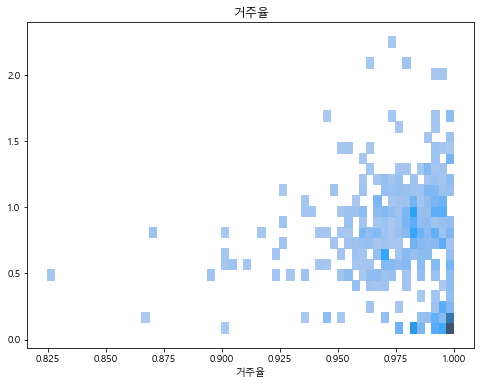

In [382]:
plt.figure(figsize=(8,6))
sns.histplot(x=train['거주율'],y=train['등록차량수']/train['총세대수'],data=train)
plt.title('거주율')
plt.show()

In [383]:
# 이상치 제거방법
# train=train.drop(train[(train['주차면수 대비 등록차량 비율'] > 2.0 )|
#                                 (train_df['주차면수 대비 총세대수'] > 1.4).index)

In [384]:
#train.corr()['등록차량수']
corr_ranks = abs(train.corr()["등록차량수"]).sort_values(ascending=False)
corr_ranks

등록차량수               1.000000
단지내주차면수             0.861338
주차면수 대비 총세대수        0.600569
주차면수 대비 등록차량 비율     0.456048
전용면적                0.335886
총세대수                0.333440
주차면수 대비 전용면적별세대수    0.253235
전용면적별세대수            0.250513
거주율                 0.189380
공가수                 0.118910
단지코드_Type           0.109893
10분내지하철수            0.107308
10분내버스정류장수          0.104135
Name: 등록차량수, dtype: float64

<AxesSubplot:>

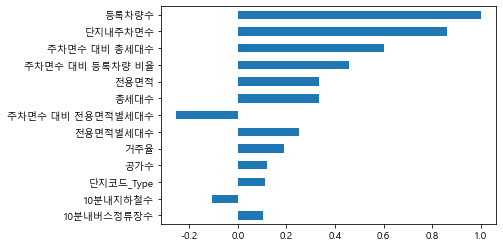

In [385]:
train.corr()["등록차량수"][corr_ranks.index[::-1]].plot(kind="barh")

In [386]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '10분내지하철수', '10분내버스정류장수', '단지내주차면수', '등록차량수',
       '단지코드_Type', '주차면수 대비 등록차량 비율', '주차면수 대비 총세대수', '주차면수 대비 전용면적별세대수',
       '거주율'],
      dtype='object')

### 10분내 버스와 지하철이 많은 주거지역은 주차수요가 낮을것이다
 > 대중교통의 편의성여부로 나눠보자

In [387]:
null_sub=train.loc[train['10분내지하철수'].isnull()].sort_values(by=['지역'])
null_sub['지역'].unique()

array(['경상남도', '대전광역시', '충청남도'], dtype=object)

 - 경상남도: 부산, 김해 지하철뿐 > 부산은 부산광역시로 따로 분류
 - 대전: 대전지하철
 - 충청남도: 천안 1호선
 > 대전은 빈도값으로 넣고 나머지는 0으로

In [388]:
null_sub_test=test.loc[test['10분내지하철수'].isnull()].sort_values(by=['지역'])
null_sub_test['지역'].unique()

array(['대전광역시', '충청남도'], dtype=object)

In [389]:
daejeon=train.loc[train['지역']=='대전광역시'].sort_values(by=['10분내지하철수'])
daejeon['10분내지하철수'].value_counts()

1.0    125
0.0     48
Name: 10분내지하철수, dtype: int64

In [390]:
daejeon_test=test.loc[test['지역']=='대전광역시'].sort_values(by=['10분내지하철수'])
daejeon_test['10분내지하철수'].value_counts()

2.0    27
0.0    14
1.0     6
Name: 10분내지하철수, dtype: int64

In [391]:
#대전꺼만 빈도수로 넣기
train.loc[(train["10분내지하철수"].isna()) & (train["지역"] == "대전광역시"), "10분내지하철수"] = 1
test.loc[(test["10분내지하철수"].isna()) & (test["지역"] == "대전광역시"), "10분내지하철수"] = 2
train[train["지역"] == "대전광역시"]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,10분내지하철수,10분내버스정류장수,단지내주차면수,등록차량수,단지코드_Type,주차면수 대비 등록차량 비율,주차면수 대비 총세대수,주차면수 대비 전용면적별세대수,거주율
7,C1407,1216,아파트,대전광역시,국민임대,30.0,288,13.0,A,15620000,127350,1.0,1.0,1285.0,1064.0,3.0,0.828016,1.056743,4.461806,0.989309
8,C1407,1216,아파트,대전광역시,국민임대,30.0,68,13.0,A,15620000,127350,1.0,1.0,1285.0,1064.0,3.0,0.828016,1.056743,18.897059,0.989309
9,C1407,1216,아파트,대전광역시,국민임대,30.0,34,13.0,A,15620000,127350,1.0,1.0,1285.0,1064.0,3.0,0.828016,1.056743,37.794118,0.989309
10,C1407,1216,아파트,대전광역시,국민임대,40.0,148,13.0,A,27637000,164610,1.0,1.0,1285.0,1064.0,3.0,0.828016,1.056743,8.682432,0.989309
11,C1407,1216,아파트,대전광역시,국민임대,40.0,74,13.0,A,27637000,164610,1.0,1.0,1285.0,1064.0,3.0,0.828016,1.056743,17.364865,0.989309
12,C1407,1216,아파트,대전광역시,국민임대,40.0,70,13.0,A,27637000,164610,1.0,1.0,1285.0,1064.0,3.0,0.828016,1.056743,18.357143,0.989309
13,C1407,1216,아파트,대전광역시,국민임대,40.0,70,13.0,A,27637000,164610,1.0,1.0,1285.0,1064.0,3.0,0.828016,1.056743,18.357143,0.989309
14,C1407,1216,아파트,대전광역시,국민임대,45.0,170,13.0,A,36048000,198250,1.0,1.0,1285.0,1064.0,3.0,0.828016,1.056743,7.558824,0.989309
15,C1407,1216,아파트,대전광역시,국민임대,45.0,170,13.0,A,36048000,198250,1.0,1.0,1285.0,1064.0,3.0,0.828016,1.056743,7.558824,0.989309
16,C1407,1216,아파트,대전광역시,국민임대,50.0,62,13.0,A,42056000,253520,1.0,1.0,1285.0,1064.0,3.0,0.828016,1.056743,20.725806,0.989309


In [392]:
#나머지 지역은 0으로
train['10분내지하철수']=train['10분내지하철수'].fillna(0)
test['10분내지하철수']=test['10분내지하철수'].fillna(0)

In [393]:
print(train['10분내지하철수'].isnull().sum())
print(test['10분내지하철수'].isnull().sum())

0
0


In [394]:
#강사님꺼
train.loc[train['10분내버스정류장수'].isnull(),"10분내버스정류장수"]=5
train.loc[train['10분내버스정류장수'].isnull(),:]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,10분내지하철수,10분내버스정류장수,단지내주차면수,등록차량수,단지코드_Type,주차면수 대비 등록차량 비율,주차면수 대비 총세대수,주차면수 대비 전용면적별세대수,거주율


In [395]:
print(train['10분내지하철수'].value_counts())
print(train['10분내버스정류장수'].value_counts())

0.0    2364
1.0     493
2.0      33
3.0       6
Name: 10분내지하철수, dtype: int64
2.0     776
3.0     737
4.0     485
1.0     270
5.0     166
6.0     153
8.0      99
10.0     80
7.0      65
12.0     22
20.0     15
15.0     11
16.0      6
19.0      4
11.0      3
14.0      2
0.0       2
Name: 10분내버스정류장수, dtype: int64


In [396]:
print(train['10분내버스정류장수'].describe())

count    2896.000000
mean        3.705110
std         2.665468
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        20.000000
Name: 10분내버스정류장수, dtype: float64


 - 10분내(1km). 버스정류장은 몇개를 기준으로 나눌까?  25%까지(0~1), 50%까지(2~3),75%까지(4), 100%까지(~20) >4구역*2개
 - 버스정류장 인근 ‘버세권’ 아파트, 교통편리성 높아 선호도↑
[출처: 서울신문에서 제공하는 기사입니다.] https://nownews.seoul.co.kr/news/newsView.php?id=20170113601003#csidx50f0b31e21d572c876df2664656aaf2 

In [397]:
# #구간설정하기: 4*2=8
# train.loc[(train('10분내지하철수')==0)&(train('10분내버스정류장')<=1),'역세권']=1
# train.loc[(train('10분내지하철수')==0)&(train('10분내버스정류장')>1)&(train('10분내버스정류장')<=3),'역세권']=2
# train.loc[(train('10분내지하철수')==0)&(train('10분내버스정류장')==4),'역세권']=3
# train.loc[(train('10분내지하철수')==0)&(train('10분내버스정류장')>1)&(train('10분내버스정류장')<=2),'역세권']=4
# train.loc[(train('10분내지하철수')==1)&(train('10분내버스정류장')<=1),'역세권']=5
# train.loc[(train('10분내지하철수')==1)&(train('10분내버스정류장')>1)&(train('10분내버스정류장')<=3),'역세권']=6
# train.loc[(train('10분내지하철수')==1)&(train('10분내버스정류장')==4),'역세권']=7
# train.loc[(train('10분내지하철수')==1)&(train('10분내버스정류장')>1)&(train('10분내버스정류장')<=2),'역세권']=8

### 1000세대 이상 대단지로 분류. 대단지는 교통시설이 좋아 주차수요가 낮을것이다
 - 생활편의시설 및 학군, 교통: 사람들이 많으면 상가들도 더 많이 들어서고, 커뮤니티 시설도 더 많이 지을 수 있다. 게다가 대단지 아파트는 학교가 근처에 있는 경우가 많아 학군 형성이 잘 되어 있는 편이며, 지자체 등에서도 버스노선 확충 등 교통여건 개선을 위해 노력할 가능성도 높아진다.
 > 바로 쓰면 너무 feature_importances를 차지해버려서 단지구분을 어케 묶을지 고민해보자. 소단지. 중단지. 대단지. 주상복합. 이런식으로?! 

In [398]:
train.loc[train['총세대수']>=1000,'대단지']=0
train.loc[train['총세대수']<1000,'대단지']=1
test.loc[test['총세대수']>=1000,'대단지']=0
test.loc[test['총세대수']<1000,'대단지']=1
train['대단지']=train['대단지'].astype('category')
test['대단지']=test['대단지'].astype('category')

In [399]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '10분내지하철수', '10분내버스정류장수', '단지내주차면수', '등록차량수',
       '단지코드_Type', '주차면수 대비 등록차량 비율', '주차면수 대비 총세대수', '주차면수 대비 전용면적별세대수',
       '거주율', '대단지'],
      dtype='object')

In [400]:
danji=train.loc[train['대단지']==0].sort_values(by=['단지코드'])
print(danji['단지코드'].unique())
print(danji['단지코드'].count())

['C1005' 'C1013' 'C1017' 'C1109' 'C1129' 'C1156' 'C1176' 'C1177' 'C1210'
 'C1236' 'C1244' 'C1268' 'C1310' 'C1320' 'C1326' 'C1329' 'C1350' 'C1363'
 'C1386' 'C1406' 'C1407' 'C1430' 'C1439' 'C1448' 'C1451' 'C1565' 'C1579'
 'C1584' 'C1616' 'C1620' 'C1672' 'C1677' 'C1689' 'C1724' 'C1802' 'C1833'
 'C1859' 'C1863' 'C1875' 'C1889' 'C1933' 'C1939' 'C1969' 'C2000' 'C2034'
 'C2046' 'C2071' 'C2086' 'C2132' 'C2135' 'C2190' 'C2225' 'C2274' 'C2276'
 'C2289' 'C2310' 'C2316' 'C2328' 'C2329' 'C2352' 'C2358' 'C2361' 'C2362'
 'C2377' 'C2393' 'C2446' 'C2460' 'C2488' 'C2489' 'C2506' 'C2507' 'C2538'
 'C2565' 'C2579' 'C2583' 'C2597' 'C2612' 'C2618' 'C2620' 'C2621' 'C2666'
 'N1036' 'N2085' 'N2431']
956


In [401]:
train.corr()['등록차량수']

총세대수                0.333440
전용면적                0.335886
전용면적별세대수            0.250513
공가수                 0.118910
10분내지하철수           -0.081121
10분내버스정류장수          0.104964
단지내주차면수             0.861338
등록차량수               1.000000
단지코드_Type           0.109893
주차면수 대비 등록차량 비율     0.456048
주차면수 대비 총세대수        0.600569
주차면수 대비 전용면적별세대수   -0.253235
거주율                 0.189380
Name: 등록차량수, dtype: float64

<AxesSubplot:>

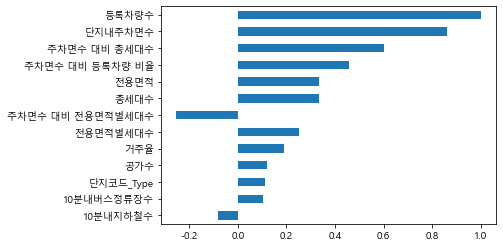

In [402]:
corr_ranks = abs(train.corr()["등록차량수"]).sort_values(ascending=False)
train.corr()["등록차량수"][corr_ranks.index[::-1]].plot(kind="barh")

### 주상복합(상가+apt)은 주차수요가 높을것이다
 - 1:상가만, 2:상가+apt, 3:apt

In [403]:
# train.loc[(train["공급유형"]=='임대상가') & (train["임대건물구분"] == "아파트")].sort_values(by=['단지코드'])
train.loc[train['임대건물구분']=='상가'].sort_values(by=['단지코드'])

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,10분내지하철수,10분내버스정류장수,단지내주차면수,등록차량수,단지코드_Type,주차면수 대비 등록차량 비율,주차면수 대비 총세대수,주차면수 대비 전용면적별세대수,거주율,대단지
773,C1004,521,상가,충청남도,임대상가,50.0,1,3.0,D,NaN,...,0.0,2.0,153.0,93.0,3.0,0.607843,0.293666,153.0,0.994242,1.0
766,C1004,521,상가,충청남도,임대상가,20.0,1,3.0,D,NaN,...,0.0,2.0,153.0,93.0,3.0,0.607843,0.293666,153.0,0.994242,1.0
765,C1004,521,상가,충청남도,임대상가,20.0,1,3.0,D,NaN,...,0.0,2.0,153.0,93.0,3.0,0.607843,0.293666,153.0,0.994242,1.0
764,C1004,521,상가,충청남도,임대상가,20.0,1,3.0,D,NaN,...,0.0,2.0,153.0,93.0,3.0,0.607843,0.293666,153.0,0.994242,1.0
763,C1004,521,상가,충청남도,임대상가,20.0,1,3.0,D,NaN,...,0.0,2.0,153.0,93.0,3.0,0.607843,0.293666,153.0,0.994242,1.0
762,C1004,521,상가,충청남도,임대상가,20.0,1,3.0,D,NaN,...,0.0,2.0,153.0,93.0,3.0,0.607843,0.293666,153.0,0.994242,1.0
761,C1004,521,상가,충청남도,임대상가,20.0,1,3.0,D,NaN,...,0.0,2.0,153.0,93.0,3.0,0.607843,0.293666,153.0,0.994242,1.0
760,C1004,521,상가,충청남도,임대상가,15.0,1,3.0,D,NaN,...,0.0,2.0,153.0,93.0,3.0,0.607843,0.293666,153.0,0.994242,1.0
759,C1004,521,상가,충청남도,임대상가,15.0,1,3.0,D,NaN,...,0.0,2.0,153.0,93.0,3.0,0.607843,0.293666,153.0,0.994242,1.0
758,C1004,521,상가,충청남도,임대상가,15.0,1,3.0,D,NaN,...,0.0,2.0,153.0,93.0,3.0,0.607843,0.293666,153.0,0.994242,1.0


#### 상가만 뽑음 (train)

In [404]:
mix_apt=train.loc[train['임대건물구분']=='상가'].sort_values(by=['단지코드'])
mix_apt['단지코드'].unique()

array(['C1004', 'C1056', 'C1109', 'C1206', 'C1439', 'C1476', 'C1616',
       'C1698', 'C1704', 'C1722', 'C1775', 'C1790', 'C1859', 'C1874',
       'C1875', 'C1899', 'C1925', 'C1983', 'C2034', 'C2038', 'C2109',
       'C2132', 'C2135', 'C2190', 'C2212', 'C2258', 'C2289', 'C2310',
       'C2416', 'C2571', 'C2597', 'C2621', 'C2644'], dtype=object)

#### 상가만 뽑음 (test)

In [405]:
mix_apt_test=test.loc[test['임대건물구분']=='상가'].sort_values(by=['단지코드'])
mix_apt_test['단지코드'].unique()

array(['C1006', 'C1729', 'C1812', 'C2033', 'C2177', 'C2253', 'C2676'],
      dtype=object)

#### 상가뽑은거 주상복합 (1) , train

In [406]:
sel=['C1004', 'C1056', 'C1109', 'C1206', 'C1439', 'C1476', 'C1616',
       'C1698', 'C1704', 'C1722', 'C1775', 'C1790', 'C1859', 'C1874',
       'C1875', 'C1899', 'C1925', 'C1983', 'C2034', 'C2038', 'C2109',
       'C2132', 'C2135', 'C2190', 'C2212', 'C2258', 'C2289', 'C2310',
       'C2416', 'C2571', 'C2597', 'C2621', 'C2644']
#train.loc[train['단지코드']=='C1004']
for one in sel:
    train.loc[ train['단지코드'] == one, "주상복합" ] = 1
print(len(mix_apt['단지코드'].unique()))
train.loc[train['주상복합']==1].sort_values(by='단지코드')

33


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,10분내버스정류장수,단지내주차면수,등록차량수,단지코드_Type,주차면수 대비 등록차량 비율,주차면수 대비 총세대수,주차면수 대비 전용면적별세대수,거주율,대단지,주상복합
765,C1004,521,상가,충청남도,임대상가,20.0,1,3.0,D,NaN,...,2.0,153.0,93.0,3.0,0.607843,0.293666,153.000000,0.994242,1.0,1.0
762,C1004,521,상가,충청남도,임대상가,20.0,1,3.0,D,NaN,...,2.0,153.0,93.0,3.0,0.607843,0.293666,153.000000,0.994242,1.0,1.0
761,C1004,521,상가,충청남도,임대상가,20.0,1,3.0,D,NaN,...,2.0,153.0,93.0,3.0,0.607843,0.293666,153.000000,0.994242,1.0,1.0
760,C1004,521,상가,충청남도,임대상가,15.0,1,3.0,D,NaN,...,2.0,153.0,93.0,3.0,0.607843,0.293666,153.000000,0.994242,1.0,1.0
759,C1004,521,상가,충청남도,임대상가,15.0,1,3.0,D,NaN,...,2.0,153.0,93.0,3.0,0.607843,0.293666,153.000000,0.994242,1.0,1.0
758,C1004,521,상가,충청남도,임대상가,15.0,1,3.0,D,NaN,...,2.0,153.0,93.0,3.0,0.607843,0.293666,153.000000,0.994242,1.0,1.0
757,C1004,521,아파트,충청남도,영구임대,35.0,264,3.0,C,4728000,...,2.0,153.0,93.0,3.0,0.607843,0.293666,0.579545,0.994242,1.0,1.0
756,C1004,521,아파트,충청남도,영구임대,35.0,240,3.0,C,4682000,...,2.0,153.0,93.0,3.0,0.607843,0.293666,0.637500,0.994242,1.0,1.0
766,C1004,521,상가,충청남도,임대상가,20.0,1,3.0,D,NaN,...,2.0,153.0,93.0,3.0,0.607843,0.293666,153.000000,0.994242,1.0,1.0
763,C1004,521,상가,충청남도,임대상가,20.0,1,3.0,D,NaN,...,2.0,153.0,93.0,3.0,0.607843,0.293666,153.000000,0.994242,1.0,1.0


#### 상가뽑은거 주상복합 (1) , test

In [407]:
sel=['C1006', 'C1729', 'C1812', 'C2033', 'C2177', 'C2253', 'C2676']
for one in sel:
    test.loc[ test['단지코드'] == one, "주상복합" ] = 1
print(len(mix_apt_test['단지코드'].unique()))
test.loc[test['주상복합']==1].sort_values(by='단지코드')

7


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,10분내지하철수,10분내버스정류장수,단지내주차면수,단지코드_Type,주차면수 대비 등록차량 비율,주차면수 대비 총세대수,주차면수 대비 전용면적별세대수,거주율,대단지,주상복합
73,C1006,1505,아파트,대전광역시,영구임대,25.0,358,27.0,C,5787000,...,2.0,5.0,428.0,3.0,1.964953,0.284385,1.195531,0.982060,0.0,1.0
99,C1006,1505,상가,대전광역시,임대상가,100.0,1,27.0,D,NaN,...,2.0,5.0,428.0,3.0,0.144860,0.284385,428.000000,0.982060,0.0,1.0
97,C1006,1505,상가,대전광역시,임대상가,50.0,1,27.0,D,NaN,...,2.0,5.0,428.0,3.0,0.144860,0.284385,428.000000,0.982060,0.0,1.0
96,C1006,1505,상가,대전광역시,임대상가,50.0,1,27.0,D,NaN,...,2.0,5.0,428.0,3.0,0.144860,0.284385,428.000000,0.982060,0.0,1.0
95,C1006,1505,상가,대전광역시,임대상가,50.0,1,27.0,D,NaN,...,2.0,5.0,428.0,3.0,0.144860,0.284385,428.000000,0.982060,0.0,1.0
94,C1006,1505,상가,대전광역시,임대상가,50.0,1,27.0,D,NaN,...,2.0,5.0,428.0,3.0,0.144860,0.284385,428.000000,0.982060,0.0,1.0
93,C1006,1505,상가,대전광역시,임대상가,50.0,1,27.0,D,NaN,...,2.0,5.0,428.0,3.0,0.144860,0.284385,428.000000,0.982060,0.0,1.0
92,C1006,1505,상가,대전광역시,임대상가,35.0,1,27.0,D,NaN,...,2.0,5.0,428.0,3.0,0.144860,0.284385,428.000000,0.982060,0.0,1.0
91,C1006,1505,상가,대전광역시,임대상가,35.0,1,27.0,D,NaN,...,2.0,5.0,428.0,3.0,0.144860,0.284385,428.000000,0.982060,0.0,1.0
90,C1006,1505,상가,대전광역시,임대상가,35.0,1,27.0,D,NaN,...,2.0,5.0,428.0,3.0,0.144860,0.284385,428.000000,0.982060,0.0,1.0


In [408]:
len(train['주상복합']==1)

2896

#### train, test 1에서 아파트를 뽑아 2로 저장

In [329]:
train.loc[(train["주상복합"]==1) & (train["임대건물구분"] == "아파트"),'주상복합']=2
test.loc[(train["주상복합"]==1) & (test["임대건물구분"] == "아파트"),'주상복합']=2
train.loc[train['주상복합'].isna(), "주상복합"] = 3
test.loc[test['주상복합'].isna(), "주상복합"] = 3
print(train['주상복합'].value_counts())
print(test['주상복합'].value_counts())

3.0    2232
1.0     562
2.0     102
Name: 주상복합, dtype: int64
2.0    434
3.0    382
1.0    192
Name: 주상복합, dtype: int64


In [414]:
train['총세대수'].max()

2568

In [409]:
train.loc[(train["주상복합"]==1) & (train["임대건물구분"] == "아파트"),'주상복합']=2
test.loc[(train["주상복합"]==1) & (test["임대건물구분"] == "아파트"),'주상복합']=2

In [410]:
apt_with_sanga_code = sorted(train.loc[(train["주상복합"] == 2)].단지코드.unique())

In [411]:
for code in apt_with_sanga_code:
  train.loc[(train["단지코드"] == code) & train["임대건물구분"] == "상가", "주상복합"] = 2

In [412]:
train.주상복합.unique() ## 1이 남아있는 것을 보아 상가만 있는 곳은 1로 아직도 남아있다.

array([nan,  2.,  1.])

In [413]:
train.loc[train["주상복합"]==2]['단지코드'].unique()

array(['C1925', 'C1874', 'C2416', 'C2621', 'C1616', 'C1704', 'C2258',
       'C2038', 'C1859', 'C1722', 'C2190', 'C1476', 'C1983', 'C2135',
       'C2034', 'C1109', 'C2289', 'C2597', 'C2310', 'C2132', 'C1439',
       'C1899', 'C1056', 'C2644', 'C1206', 'C1775', 'C1790', 'C2109',
       'C1698', 'C1004', 'C1875', 'C2212', 'C2571'], dtype=object)

In [416]:
train.loc[train['주상복합'].isna(), "주상복합"] = 3
test.loc[test['주상복합'].isna(), "주상복합"] = 3

In [419]:
len(train['주상복합']==1)

2896

In [421]:
train.corr()

,총세대수,전용면적,전용면적별세대수,공가수,10분내지하철수,10분내버스정류장수,단지내주차면수,등록차량수,단지코드_Type,주차면수 대비 등록차량 비율,주차면수 대비 총세대수,주차면수 대비 전용면적별세대수,거주율,주상복합
총세대수,1.000000,-0.097571,0.098876,0.066245,0.224775,-0.002570,0.522593,0.333440,0.095184,-0.304020,-0.275524,0.577218,0.418223,-0.355321
전용면적,-0.097571,1.000000,0.022416,-0.099646,-0.064642,0.024582,0.212888,0.335886,0.109671,0.308939,0.424882,-0.131576,0.083095,0.256970
전용면적별세대수,0.098876,0.022416,1.000000,0.162061,-0.054476,0.045578,0.283585,0.250513,-0.012913,0.055718,0.208902,-0.346555,0.027991,0.301818
공가수,0.066245,-0.099646,0.162061,1.000000,-0.075899,0.044062,0.288062,0.118910,-0.169005,-0.154627,0.221879,-0.233833,-0.557004,0.269188
10분내지하철수,0.224775,-0.064642,-0.054476,-0.075899,1.000000,0.092527,-0.037206,-0.081121,0.044681,-0.215906,-0.183996,0.240450,0.103547,-0.229012
10분내버스정류장수,-0.002570,0.024582,0.045578,0.044062,0.092527,1.000000,0.073722,0.104964,-0.003684,0.065948,0.021253,-0.099586,0.036730,0.002520
단지내주차면수,0.522593,0.212888,0.283585,0.288062,-0.037206,0.073722,1.000000,0.861338,0.064013,0.046695,0.582550,-0.134243,0.188190,0.447303
등록차량수,0.333440,0.335886,0.250513,0.118910,-0.081121,0.104964,0.861338,1.000000,0.109893,0.456048,0.600569,-0.253235,0.189380,0.486160
단지코드_Type,0.095184,0.109671,-0.012913,-0.169005,0.044681,-0.003684,0.064013,0.109893,1.000000,0.062202,0.011308,0.091031,0.181392,-0.087577
주차면수 대비 등록차량 비율,-0.304020,0.308939,0.055718,-0.154627,-0.215906,0.065948,0.046695,0.456048,0.062202,1.000000,0.335587,-0.380764,-0.040154,0.386854


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,10분내버스정류장수,단지내주차면수,등록차량수,단지코드_Type,주차면수 대비 등록차량 비율,주차면수 대비 총세대수,주차면수 대비 전용면적별세대수,거주율,대단지,주상복합
0,C2515,545,아파트,경상남도,국민임대,30.0,276,17.0,A,9216000,...,3.0,624.0,205.0,3.0,0.328526,1.144954,2.260870,0.968807,1.0,3.0
1,C2515,545,아파트,경상남도,국민임대,35.0,60,17.0,A,12672000,...,3.0,624.0,205.0,3.0,0.328526,1.144954,10.400000,0.968807,1.0,3.0
2,C2515,545,아파트,경상남도,국민임대,35.0,20,17.0,A,12672000,...,3.0,624.0,205.0,3.0,0.328526,1.144954,31.200000,0.968807,1.0,3.0
3,C2515,545,아파트,경상남도,국민임대,45.0,38,17.0,A,18433000,...,3.0,624.0,205.0,3.0,0.328526,1.144954,16.421053,0.968807,1.0,3.0
4,C2515,545,아파트,경상남도,국민임대,45.0,19,17.0,A,18433000,...,3.0,624.0,205.0,3.0,0.328526,1.144954,32.842105,0.968807,1.0,3.0


In [258]:
len(train.loc[train['주상복합'] == '1'])

562

In [184]:
train.loc[train["주상복합"]==2]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,10분내버스정류장수,단지내주차면수,등록차량수,단지코드_Type,주차면수 대비 등록차량 비율,주차면수 대비 총세대수,주차면수 대비 전용면적별세대수,거주율,대단지,주상복합
78,C1925,601,아파트,강원도,영구임대,25.0,298,9.0,C,8052000,...,4.0,117.0,75.0,1.0,0.641026,0.194676,0.392617,0.985025,1.0,2.0
79,C1925,601,아파트,강원도,영구임대,30.0,298,9.0,C,9174000,...,4.0,117.0,75.0,1.0,0.641026,0.194676,0.392617,0.985025,1.0,2.0
80,C1925,601,상가,강원도,임대상가,30.0,1,9.0,D,NaN,...,4.0,117.0,75.0,1.0,0.641026,0.194676,117.000000,0.985025,1.0,2.0
81,C1925,601,상가,강원도,임대상가,30.0,1,9.0,D,NaN,...,4.0,117.0,75.0,1.0,0.641026,0.194676,117.000000,0.985025,1.0,2.0
82,C1925,601,상가,강원도,임대상가,30.0,1,9.0,D,NaN,...,4.0,117.0,75.0,1.0,0.641026,0.194676,117.000000,0.985025,1.0,2.0
83,C1925,601,상가,강원도,임대상가,70.0,1,9.0,D,NaN,...,4.0,117.0,75.0,1.0,0.641026,0.194676,117.000000,0.985025,1.0,2.0
90,C1874,619,아파트,충청남도,영구임대,25.0,294,2.0,C,3141000,...,2.0,97.0,62.0,3.0,0.639175,0.156704,0.329932,0.996769,1.0,2.0
91,C1874,619,아파트,충청남도,영구임대,25.0,149,2.0,C,3141000,...,2.0,97.0,62.0,3.0,0.639175,0.156704,0.651007,0.996769,1.0,2.0
92,C1874,619,아파트,충청남도,영구임대,30.0,149,2.0,C,3731000,...,2.0,97.0,62.0,3.0,0.639175,0.156704,0.651007,0.996769,1.0,2.0
93,C1874,619,상가,충청남도,임대상가,15.0,1,2.0,D,NaN,...,2.0,97.0,62.0,3.0,0.639175,0.156704,97.000000,0.996769,1.0,2.0


In [73]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '10분내지하철수', '10분내버스정류장수', '단지내주차면수', '등록차량수',
       '단지코드_Type', '주차면수 대비 등록차량 비율', '주차면수 대비 총세대수', '주차면수 대비 전용면적별세대수',
       '거주율', '대단지', '주상복합'],
      dtype='object')

In [74]:
# train['주상복합'].corr()["등록차량수"].plot(kind="bar")

### 자격유형에 따라 공급유형이 정해져있다. 공급유형에 따른 자격조건을 확인. 저소득층일 수록 주차수요가 낮을 것이다

In [75]:
train['공급유형'].unique()

array(['국민임대', '공공임대(50년)', '영구임대', '임대상가', '공공임대(10년)', '공공임대(분납)',
       '장기전세', '공공분양', '행복주택', '공공임대(5년)'], dtype=object)

##### 임대주택(국민임대,영구임대,공공임대,장기전세,행복주택)
 - 기준: 마이홈(https://www.myhome.go.kr/hws/portal/cont/selectContRentalView.do#guide=RH101)

In [76]:
#생계급여 또는 의료급여 수급자 등 [소득 1분위]
a=train.loc[train['공급유형']=='영구임대'].sort_values(by=['자격유형'])
a['자격유형'].unique()

array(['A', 'C', 'E', 'F', 'I'], dtype=object)

In [77]:
#무주택세대구성원[소득 2~4분위], 총자산: 29,200만원이하, 자동차: 3,496만원이하
a=train.loc[train['공급유형']=='국민임대'].sort_values(by=['자격유형'])
a['자격유형'].unique()

array(['A', 'B', 'E', 'G', 'H'], dtype=object)

In [78]:
#무주택세대구성원[소득 3~4분위], 부동산: 21,550만원이하, 자동차: 3,496만원이하
a=train.loc[train['공급유형']=='장기전세'].sort_values(by=['자격유형'])
a['자격유형'].unique()

array(['A'], dtype=object)

In [79]:
#무주택세대구성원[소득 3~5분위],부동산: 21,550만원이하,자동차: 3,496만원이하
a=train.loc[train['공급유형']=='공공임대(50년)'].sort_values(by=['자격유형'])
a['자격유형'].unique()

array(['A'], dtype=object)

In [80]:
a=train.loc[train['공급유형']=='공공임대(10년)'].sort_values(by=['자격유형'])
a['자격유형'].unique()

array(['A'], dtype=object)

In [81]:
a=train.loc[train['공급유형']=='공공임대(분납)'].sort_values(by=['자격유형'])
a['자격유형'].unique()

array(['A'], dtype=object)

In [82]:
a=train.loc[train['공급유형']=='공공임대(5년)'].sort_values(by=['자격유형'])
a['자격유형'].unique()

array(['A'], dtype=object)

In [83]:
#무주택세대구성원/무주택자[소득 2~5분위],총자산: 29,200만원이하,자동차: 3,496만원이하
a=train.loc[train['공급유형']=='행복주택'].sort_values(by=['자격유형'])
a['자격유형'].unique()

array(['J', 'K', 'L', 'M', 'N', 'O'], dtype=object)

##### 공공분양주택
 - 소득이 낮은 무주택서민이거나 국가유공자, 장애인, 신혼부부, 다자녀가구,
노부모 부양자 등 정책적 배려가 필요한 사회계층의 주택마련을 지원하기
위한 제도 

In [84]:
# 전용면적40m(12평)초과: 3년 이상의 기간동안 무주택세대구성원으로서 저축총액이 많은 분
# 전용면적40m(12평)미만: 3년 이상의 기간동안 무주택세대구성원으로서 납입횟수가 많은 분
a=train.loc[train['공급유형']=='공공분양'].sort_values(by=['자격유형'])
a['자격유형'].unique()

array(['D'], dtype=object)

##### 공공임대상가
 - 신규 공공주택 단지 내 상가의 60~80% 수준을 청년, 사회적기업, 소상공인 등에게 임대(시세 50~80%)하는 공공지원형 상가로 전환

In [85]:
#영세 소상공인(소득 월 400만원 이하)
a=train.loc[train['공급유형']=='임대상가'].sort_values(by=['자격유형'])
a['자격유형'].unique()

array(['D'], dtype=object)

##### 자격유형별(15개) 공급유형(10개)
 - 가구특성별 소득분위별 가구소득(KOSIS)
 (https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1HDLA08)
 - A: 국민임대, 공공임대(50년,10년,분납,5년) ,영구임대,장기전세
 - B: 국민임대
 - C: 영구임대
 - D: 임대상가, 공공분양
 - E: 국민임대, 영구임대
 - F: 영구임대
 - G: 국민임대
 - H: 국민임대
 - I: 영구임대
 - J: 행복주택
 - K: 행복주택
 - L: 행복주택
 - M: 행복주택
 - N: 행복주택
 - O: 행복주택

In [86]:
#소득분위를 나눠보자...

### 분양은 임대보증금과 임대료가 없다. 전세는 임대료가 없다. 임대상가는 시세 대비 80% 수준의 저렴한 임대료로 공급.

 - 공공분양 결측치 처리

In [87]:
grouped=train.groupby(['임대보증금'])
group1=grouped.get_group(('-'))
a=group1.index
for x in a:
    train.loc[x,'임대보증금'] = 0
grouped1=train.groupby(['임대료'])
group2=grouped1.get_group(('-'))
a=group2.index
for x in a:
    train.loc[x,'임대료']=0

In [88]:
grouped=test.groupby(['임대보증금'])
group1=grouped.get_group(('-'))
a=group1.index
for x in a:
    test.loc[x,'임대보증금'] = 0
grouped1=test.groupby(['임대료'])
group2=grouped1.get_group(('-'))
a=group2.index
for x in a:
    test.loc[x,'임대료']=0

In [89]:
a=train.loc[train['임대보증금'].isnull()].sort_values(by=['단지코드'])
a['공급유형'].unique()

array(['임대상가', '공공분양'], dtype=object)

In [90]:
a=train.loc[train['임대료'].isnull()].sort_values(by=['단지코드'])
a['공급유형'].unique()

array(['임대상가', '공공분양'], dtype=object)

In [91]:
train.loc[train['공급유형']=='공공분양'].sort_values(by=['임대료'])

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,10분내버스정류장수,단지내주차면수,등록차량수,단지코드_Type,주차면수 대비 등록차량 비율,주차면수 대비 총세대수,주차면수 대비 전용면적별세대수,거주율,대단지,주상복합
2309,C1350,1401,아파트,대전광역시,공공분양,70.0,317,2.0,D,NaN,...,6.0,1636.0,2315.0,3.0,1.415037,1.167737,5.160883,0.998572,0.0,3.0
2310,C1350,1401,아파트,대전광역시,공공분양,70.0,137,2.0,D,NaN,...,6.0,1636.0,2315.0,3.0,1.415037,1.167737,11.941606,0.998572,0.0,3.0
2311,C1350,1401,아파트,대전광역시,공공분양,70.0,22,2.0,D,NaN,...,6.0,1636.0,2315.0,3.0,1.415037,1.167737,74.363636,0.998572,0.0,3.0
2312,C1350,1401,아파트,대전광역시,공공분양,80.0,164,2.0,D,NaN,...,6.0,1636.0,2315.0,3.0,1.415037,1.167737,9.975610,0.998572,0.0,3.0
2313,C1350,1401,아파트,대전광역시,공공분양,80.0,19,2.0,D,NaN,...,6.0,1636.0,2315.0,3.0,1.415037,1.167737,86.105263,0.998572,0.0,3.0
2314,C1350,1401,아파트,대전광역시,공공분양,80.0,26,2.0,D,NaN,...,6.0,1636.0,2315.0,3.0,1.415037,1.167737,62.923077,0.998572,0.0,3.0
2315,C1350,1401,아파트,대전광역시,공공분양,80.0,26,2.0,D,NaN,...,6.0,1636.0,2315.0,3.0,1.415037,1.167737,62.923077,0.998572,0.0,3.0


In [92]:
train.loc[(train["임대보증금"].isna()) & (train['공급유형']== '공공분양'), "임대보증금"] =0
train.loc[(train["임대료"].isna()) & (train['공급유형']== '공공분양'), "임대료"] = 0
test.loc[(train["임대보증금"].isna()) & (test['공급유형']=='공공분양'), "임대보증금"] = 0
train.loc[(train["임대료"].isna()) & (train['공급유형']== '공공분양'), "임대료"] = 0

In [93]:
train.loc[(train['공급유형']=='공공분양').isna()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,10분내버스정류장수,단지내주차면수,등록차량수,단지코드_Type,주차면수 대비 등록차량 비율,주차면수 대비 총세대수,주차면수 대비 전용면적별세대수,거주율,대단지,주상복합


 - 장기전세 결측치 처리
 - 장기전세 보증금은 '한국토지주택공사_임대주택단지 조회 서비스' api 자료활용!
 (https://www.data.go.kr/data/15059475/openapi.do)

In [94]:
# train.loc[train['공급유형']=='장기전세'].sort_values(by=['전용면적별세대수'])

In [95]:
# train.loc[(train["임대료"].isna()) & (train['공급유형']== '장기전세'), "임대료"] = 0
# test.loc[(train["임대료"].isna()) & (test['공급유형']=='장기전세'), "임대료"] = 0

In [96]:
# train.loc[(train['공급유형']=='장기전세').isnull()]

In [97]:
# lh_code=pd.read_csv('./lhleaseinfo.csv',engine='python',encoding='cp949')
# lh_code.columns=['전용면적','월임대료','총세대수','순번','단지명','최초입주년월','지역명','세대수','전체건수','공급유형명','임대보증금']
# lh_code.sort_values(by=['세대수'])

 ##### 지역별 임대료를 찾으면 주차수요와 연결할 수 있을까?

In [98]:
# train.loc[train['임대료'].isnull()]
a=train.loc[train['임대보증금'].isnull()].sort_values(by=['단지코드'])
a['공급유형'].unique()

array(['임대상가'], dtype=object)

In [99]:
a=train.loc[train['임대료'].isnull()].sort_values(by=['단지코드'])
a['공급유형'].unique()

array(['임대상가'], dtype=object)

##### 임대상가는 어케 처리해야하나...?!

In [100]:
sanga=train.loc[train['임대건물구분']=='상가'].sort_values(by=['단지코드'])
print(sanga['단지코드'].unique())
print(len(sanga['단지코드'].unique()))

['C1004' 'C1056' 'C1109' 'C1206' 'C1439' 'C1476' 'C1616' 'C1698' 'C1704'
 'C1722' 'C1775' 'C1790' 'C1859' 'C1874' 'C1875' 'C1899' 'C1925' 'C1983'
 'C2034' 'C2038' 'C2109' 'C2132' 'C2135' 'C2190' 'C2212' 'C2258' 'C2289'
 'C2310' 'C2416' 'C2571' 'C2597' 'C2621' 'C2644']
33


### 그래프로 볼까?

In [101]:
train.corr()['등록차량수']

총세대수                0.333440
전용면적                0.335886
전용면적별세대수            0.250513
공가수                 0.118910
10분내지하철수           -0.081121
10분내버스정류장수          0.104964
단지내주차면수             0.861338
등록차량수               1.000000
단지코드_Type           0.109893
주차면수 대비 등록차량 비율     0.456048
주차면수 대비 총세대수        0.600569
주차면수 대비 전용면적별세대수   -0.253235
거주율                 0.189380
주상복합                0.497048
Name: 등록차량수, dtype: float64

(array([ 664.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2232.]),
 array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ]),
 <BarContainer object of 10 artists>)

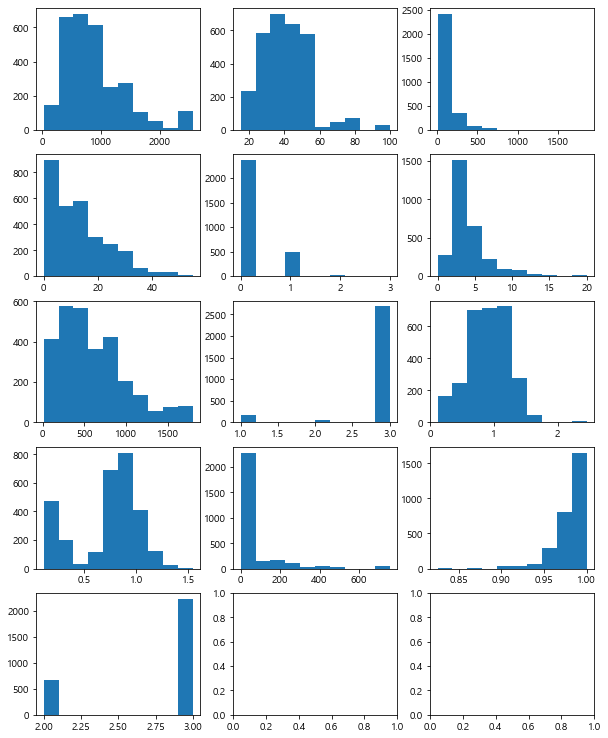

In [102]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(10,13))

ax[0][0].hist(train['총세대수'])
ax[0][1].hist(train['전용면적'])
ax[0][2].hist(train['전용면적별세대수'])

ax[1][0].hist(train['공가수'])
ax[1][1].hist(train['10분내지하철수'])
ax[1][2].hist(train['10분내버스정류장수'])

ax[2][0].hist(train['단지내주차면수'])
ax[2][1].hist(train['단지코드_Type'])
ax[2][2].hist(train['주차면수 대비 등록차량 비율'])

ax[3][0].hist(train['주차면수 대비 총세대수'])
ax[3][1].hist(train['주차면수 대비 전용면적별세대수'])
ax[3][2].hist(train['거주율'])

ax[4][0].hist(train['주상복합'])
# ax[4][1].hist(train[''])
# ax[4][2].hist(train[''])


### 경제활동나이(20~60대)가 많은 지역은 주차수요가 높을것이다

In [103]:
age

,지역,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),...,60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
0,경상북도,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,...,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
1,경상남도,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,...,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
2,대전광역시,0.028197,0.029092,0.040490,0.042793,0.060834,0.064247,0.068654,0.066848,0.074667,...,0.088468,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066
3,경기도,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,...,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
4,전라북도,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,...,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013
5,강원도,0.028888,0.030682,0.051287,0.052712,0.060374,0.063157,0.059821,0.054321,0.076201,...,0.088423,0.070014,0.047732,0.032760,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017
6,광주광역시,0.031994,0.034566,0.049851,0.050254,0.065084,0.066875,0.066888,0.064416,0.080028,...,0.075930,0.059586,0.048552,0.031754,0.029749,0.010341,0.006343,0.000895,0.000353,0.000013
7,충청남도,0.031369,0.031711,0.059077,0.062422,0.067975,0.072622,0.065095,0.067303,0.078860,...,0.070278,0.057692,0.042296,0.028682,0.024514,0.010900,0.005429,0.001549,0.000219,0.000123
8,부산광역시,0.022003,0.022947,0.032681,0.035512,0.053796,0.057233,0.047049,0.048866,0.061952,...,0.109297,0.085294,0.078743,0.053388,0.047908,0.020228,0.008043,0.002240,0.000268,0.000028
9,제주특별자치도,0.034690,0.036695,0.060094,0.063080,0.069135,0.069667,0.050808,0.048026,0.080548,...,0.074248,0.055717,0.047944,0.033054,0.026836,0.011332,0.006832,0.000982,0.000368,0.000082


In [104]:
print(age['지역'].unique())
print(train['지역'].unique())
# print(age['지역'].unique()==train['지역'].unique())

['경상북도' '경상남도' '대전광역시' '경기도' '전라북도' '강원도' '광주광역시' '충청남도' '부산광역시' '제주특별자치도'
 '울산광역시' '충청북도' '전라남도' '대구광역시' '서울특별시' '세종특별자치시']
['경상남도' '대전광역시' '경기도' '전라북도' '강원도' '광주광역시' '충청남도' '부산광역시' '제주특별자치도'
 '울산광역시' '충청북도' '전라남도' '경상북도' '대구광역시' '서울특별시' '세종특별자치시']


In [105]:
age.set_index('지역',inplace=True)
train.set_index('지역',inplace=True)

In [106]:
age_train=train.join(age)
age_train.head()

,단지코드,총세대수,임대건물구분,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,...,60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
지역,,,,,,,,,,,,,,,,,,,,,
강원도,C2073,361,아파트,국민임대,35.0,94,13.0,A,10813000,144180,...,0.088423,0.070014,0.047732,0.03276,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017
강원도,C2073,361,아파트,국민임대,35.0,74,13.0,A,10813000,144180,...,0.088423,0.070014,0.047732,0.03276,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017
강원도,C2073,361,아파트,국민임대,45.0,97,13.0,A,16821000,205460,...,0.088423,0.070014,0.047732,0.03276,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017
강원도,C2073,361,아파트,국민임대,45.0,46,13.0,A,16821000,205460,...,0.088423,0.070014,0.047732,0.03276,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017
강원도,C2073,361,아파트,국민임대,45.0,10,13.0,A,16821000,205460,...,0.088423,0.070014,0.047732,0.03276,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017


In [107]:
age_train=age_train.reset_index(drop=False)
age_train

,지역,단지코드,총세대수,임대건물구분,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
0,강원도,C2073,361,아파트,국민임대,35.0,94,13.0,A,10813000,...,0.088423,0.070014,0.047732,0.032760,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017
1,강원도,C2073,361,아파트,국민임대,35.0,74,13.0,A,10813000,...,0.088423,0.070014,0.047732,0.032760,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017
2,강원도,C2073,361,아파트,국민임대,45.0,97,13.0,A,16821000,...,0.088423,0.070014,0.047732,0.032760,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017
3,강원도,C2073,361,아파트,국민임대,45.0,46,13.0,A,16821000,...,0.088423,0.070014,0.047732,0.032760,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017
4,강원도,C2073,361,아파트,국민임대,45.0,10,13.0,A,16821000,...,0.088423,0.070014,0.047732,0.032760,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2891,충청북도,C1176,1486,아파트,국민임대,35.0,179,55.0,H,18140000,...,0.075390,0.062427,0.041814,0.027566,0.027762,0.011212,0.005386,0.001310,0.000257,0.000037
2892,충청북도,C1176,1486,아파트,국민임대,35.0,20,55.0,H,18140000,...,0.075390,0.062427,0.041814,0.027566,0.027762,0.011212,0.005386,0.001310,0.000257,0.000037
2893,충청북도,C1176,1486,아파트,국민임대,45.0,250,55.0,H,29080000,...,0.075390,0.062427,0.041814,0.027566,0.027762,0.011212,0.005386,0.001310,0.000257,0.000037
2894,충청북도,C1176,1486,아파트,국민임대,45.0,350,55.0,H,29080000,...,0.075390,0.062427,0.041814,0.027566,0.027762,0.011212,0.005386,0.001310,0.000257,0.000037


In [108]:
#10대, 20~60대, 70대~. 나눠볼까..?